In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip -n NewsAggregatorDataset.zip

ファイル `NewsAggregatorDataset.zip' はすでに存在するので、取得しません。

Archive:  NewsAggregatorDataset.zip


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
columns = [
    'ID', 
    'TITLE', 
    'URL', 
    'PUBLISHER', 
    'CATEGORY', 
    'STORY', 
    'HOSTNAME', 
    'TIMESTAMP']
df = pd.read_csv(
    'newsCorpora.csv', 
    delimiter='\t', 
    header=None,
    names=columns)
publisher_list = [
    'Reuters', 
    'Huffington Post', 
    'Businessweek', 
    'Contactmusic.com', 
    'Daily Mail'
]
df = df.query('PUBLISHER in @publisher_list')
train, test = train_test_split(df, test_size=0.2)
val, test = train_test_split(test, test_size=0.5)
train[['CATEGORY', 'TITLE']].to_csv('train.txt', sep='\t')
val[['CATEGORY', 'TITLE']].to_csv('valid.txt', sep='\t')
test[['CATEGORY', 'TITLE']].to_csv('test.txt', sep='\t')



In [46]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

vectorizer = CountVectorizer()
train_feature = vectorizer.fit_transform(train['TITLE'])
# train_feature = normalize(train_feature, norm='l1')
train_feature = train_feature.toarray()
np.savetxt('train.feature.txt', train_feature, delimiter='\t')

val_feature = vectorizer.transform(val['TITLE'])
# val_feature = normalize(val_feature, norm='l1')
val_feature = val_feature.toarray()
np.savetxt('valid.feature.txt', val_feature, delimiter='\t')

test_feature = vectorizer.transform(test['TITLE'])
# test_feature = normalize(test_feature, norm='l1')
test_feature = test_feature.toarray()
np.savetxt('test.feature.txt', test_feature, delimiter='\t')

In [19]:
train_target = train['CATEGORY']
val_target = val['CATEGORY']
test_target = test['CATEGORY']

train_target.to_csv('train.target.txt', sep='\t')
val_target.to_csv('valid.target.txt', sep='\t')
test_target.to_csv('test.target.txt', sep='\t')

In [47]:
from sklearn.linear_model import LogisticRegression

solver = 'saga'
clf = LogisticRegression(penalty='l1', solver='saga')
clf.fit(train_feature, train_target)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(penalty='l1', solver='saga')

In [48]:
train_accuracy = clf.score(train_feature, train_target)
test_accuracy = clf.score(test_feature, test_target)
print(f'Accuracy in train dataset: {train_accuracy:.3f}')
print(f'Accuracy in test dataset:  {test_accuracy:.3f}')

Accuracy in train dataset: 0.962
Accuracy in test dataset:  0.909


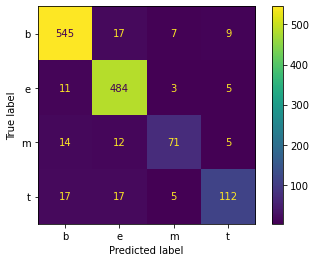

In [49]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, test_feature, test_target)

In [50]:
from sklearn.metrics import classification_report
y_true = test_target
y_pred = clf.predict(test_feature)
target_names = ['b', 'e', 'm', 't']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           b       0.93      0.94      0.94       578
           e       0.91      0.96      0.94       503
           m       0.83      0.70      0.76       102
           t       0.85      0.74      0.79       151

    accuracy                           0.91      1334
   macro avg       0.88      0.84      0.86      1334
weighted avg       0.91      0.91      0.91      1334



In [51]:
coef = clf.coef_.flatten()
coef = np.sort(coef)
print(coef[:10])
print(coef[-10:])

[-3.00034323 -2.85172746 -2.84473144 -2.23635945 -2.0136678  -1.98544131
 -1.9528516  -1.9146724  -1.87451855 -1.8494689 ]
[4.02426114 4.05687088 4.12208498 4.15606427 4.20614726 4.34783928
 4.38723351 4.46620808 4.67875643 5.97081062]


In [54]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.001, 0.01, 0.1, 1.]}
gscv = GridSearchCV(clf, parameters)
gscv.fit(train_feature, train_target)

ValueError: Found input variables with inconsistent numbers of samples: [10672, 1334]

In [ ]:
results = {
    'train': [],
    'val': [],
    'test': []
}
